ploting evidence for changes in $Dq/q$ vs $\lambda$, with $\lambda$ scaleing dR

In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy
import refnx
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Transform, CurveFitter, Objective, Model, Parameter
from refnx.reflect import SLD, Slab, ReflectModel
from sepObjective import getObjective as gO
from dynesty import DynamicNestedSampler
from dynesty import plotting as dyplot
from CFitter import CFitter
import make_sim_data as msd
print('refnx: %s\nscipy: %s\nnumpy: %s' % (refnx.version.version,
                   scipy.version.version, np.version.version))


refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4
refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4


In [2]:
def aPlotter(res, interestingNo, spacesize, figI):
    print(figI)
    # no = -1000
    # slc = slice(no-1000,no)
    useAbleLow=0.1
    useAbleHigh=10.
    xall=np.linspace(0,spacesize,len(res["logz"]))
    print("len",len(res["logz"]), "space size", spacesize)
    useable=np.transpose(np.array([[x,y] for y,x in zip(res["logz"],xall) if np.exp(y)>useAbleLow and np.exp(y)<=useAbleHigh]))
    # print(len(res["logz"]),res["logz"][slc])#summary()
    interesting = np.transpose(np.array([[x,y] for y,x in zip(res["logz"],xall) if x>=float(interestingNo)]))#.reshape((2,-2))
    print("len 2", len(interesting[0]), len(interesting), interesting[0,:3])
    print("logz max: ",max(res["logz"]),",min: ",min(res["logz"]))
    print("z max: ",max(np.exp(res["logz"])),",min: ",min(np.exp(res["logz"])))
#     print(res["logz"][:5],interesting[1,:5],useable[1,:5])
    # print("interesting")
#     xall=np.linspace(0,spacesize,len(res["logz"]))
#     xusable=np.linspace(0,spacesize,len(useable))
    plt.figure(figI)
    figI+=1
    plt.plot(xall,res["logz"])
    plt.title("ln(evidence) log scaled vs -ln(X)")
    # plt.yscale("log")
    plt.figure(figI)
    figI+=1
    plt.plot(interesting[0],interesting[1])
    plt.title(r"interesting values ln(evidence)  vs -ln(X) $\geq %d$" % interestingNo)
    if len(useable)>=2:
        plt.figure(figI)
        figI+=1
        plt.plot(useable[0],useable[1])
        plt.title(r"usful values ln(%.3f<evidence $\leq$ %.3f)  vs -ln(X)"%(useAbleLow,useAbleHigh))
    print(figI)
    return figI

In [3]:
figI = 0
# simple structure
thicks_true = [10,120,100,130,10]
bs_true = [0,5,4.5,5,10]
roughs_true = [0,0,0,0,0]
# bs = [5,4.5,5]
# thicks = [120,100,130]
# roughs = [0,0,0]
bs = bs_true
thicks = thicks_true
roughs = roughs_true
loss = 1.
no_layers = len(bs)
no_layers = len(bs_true)
# no_layers = 3
layers = []
names = []
#names = ['layer1','layer2']
for i in range(no_layers):
    names.append('layer'+str(i))
for i in range(no_layers):
        sld = SLD(bs[i],name=names[i])
        layers.append(sld(thicks[i],roughs[i]))
structure = layers[0]
for layer in layers[1:]:
    structure|=layer
print("done")

done


done


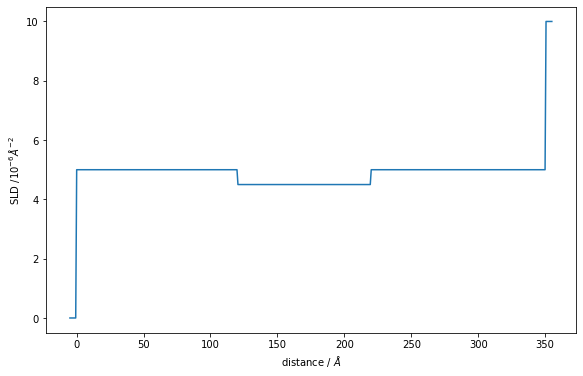

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [9.5, 6]
#notebook
plt.figure(figI)
figI+=1
plt.plot(*structure.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
print("done")

In [5]:
resolution = 5.
model = ReflectModel(structure, bkg=3e-6, dq=resolution)

csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


<ErrorbarContainer object of 3 artists>

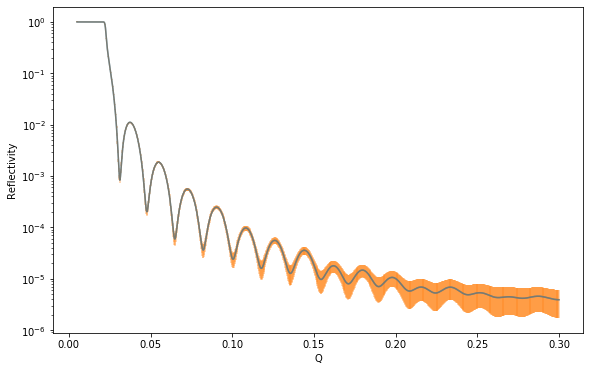

In [6]:
q = np.linspace(0.005, 0.3, 1001)
plt.figure(figI)
figI+=1
R = model(q, x_err=resolution)
plt.plot(q, R)
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.yscale('log')
#Q, R(Q), sig_Q, sig_R =
import make_sim_data as msd
sim_dR = msd.main(sim_q=q,sim_R=R)*10
R = model(q, x_err=resolution)
plt.errorbar(q,R,sim_dR, alpha=0.4)

In [7]:
data = Data1D(data= (q,R,sim_dR))

In [ ]:
resolutions = [1.,3.,7.,9.]
dRScaleBys = [5,10,15,20]
# lnPosts = []
# lnPostss = []
evidences = []
figI=1
# resolution = 5.
for dRScaleBy in dRScaleBys:
#     datas=[]
    for resolution in resolutions:
        model = ReflectModel(structure, bkg=3e-6, dq=resolution)
        q = np.linspace(0.005, 0.3, 1001)
#         plt.figure(figI)
        figI+=1
        R = model(q, x_err=resolution)
#         plt.plot(q, R)
#         plt.xlabel('Q')
#         plt.ylabel('Reflectivity')
#         plt.yscale('log')
#         plt.title('dR scaled by '+str(dRScaleBy)+' dq '+str(resolution))
        #Q, R(Q), sig_Q, sig_R =
        sim_dR = msd.main(sim_q=q,sim_R=R)*10
#         R = model(q, x_err=resolution)
#         plt.errorbar(q,R,sim_dR, alpha=0.4)
        data = Data1D(data= (q,R,sim_dR))
        objective = gO(data, 3)
        fitter = CFitter(objective)
        DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim()) #1:01:10 or 28:46 time
        DNSampler.run_nested(dlogz_init=0.01)#10000)
        res = DNSampler.results
        evidence = res["logz"][-1]
        print(evidence)
        evidences.append(evidence)
#         print(lnPost)
#         lnPosts.append(lnPost)

csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


26499it [24:55, 17.72it/s, batch: 7 | bound: 706 | nc: 8 | ncall: 646207 | eff(%):  4.101 | loglstar: -202.191 < -195.105 < -197.037 | logz: -220.134 +/-  0.292 | stop:  0.952]         


-220.11328681456592
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


28379it [08:30, 55.62it/s, batch: 8 | bound: 181 | nc: 6 | ncall: 161880 | eff(%): 17.531 | loglstar: 1000.415 < 1008.232 < 1007.220 | logz: 982.787 +/-  0.292 | stop:  0.987]          


982.7887810159078
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


32388it [24:41, 21.86it/s, batch: 8 | bound: 716 | nc: 6 | ncall: 590509 | eff(%):  5.485 | loglstar: 1075.286 < 1083.785 < 1081.905 | logz: 1055.241 +/-  0.310 | stop:  0.996]         


1055.2684365805314
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


30559it [4:44:11,  1.79it/s, batch: 7 | bound: 9951 | nc: 9 | ncall: 7637451 | eff(%):  0.400 | loglstar: -123.375 < -115.445 < -116.614 | logz: -146.484 +/-  0.325 | stop:  0.954]            


-146.47705209627895
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


30163it [13:24, 37.49it/s, batch: 8 | bound: 316 | nc: 3 | ncall: 287583 | eff(%): 10.488 | loglstar: -202.911 < -195.011 < -196.521 | logz: -220.609 +/-  0.294 | stop:  0.896]         


-220.60610280345477
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


28286it [08:12, 57.44it/s, batch: 8 | bound: 173 | nc: 3 | ncall: 156091 | eff(%): 18.121 | loglstar: 1000.488 < 1008.240 < 1007.316 | logz: 982.981 +/-  0.291 | stop:  0.962]          


982.9960603373407
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


28828it [11:10, 42.98it/s, batch: 7 | bound: 262 | nc: 13 | ncall: 232396 | eff(%): 12.405 | loglstar: 1075.951 < 1083.723 < 1081.587 | logz: 1055.021 +/-  0.312 | stop:  0.982]         


1055.0312970246378
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


27767it [30:19, 15.26it/s, batch: 6 | bound: 879 | nc: 7 | ncall: 707327 | eff(%):  3.926 | loglstar: -122.960 < -115.814 < -118.256 | logz: -146.916 +/-  0.329 | stop:  0.958]          


-146.91675261007052
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


29402it [08:33, 57.22it/s, batch: 8 | bound: 177 | nc: 4 | ncall: 157628 | eff(%): 18.653 | loglstar: -202.548 < -195.020 < -196.058 | logz: -220.605 +/-  0.294 | stop:  0.979]         


-220.6032067872486
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


30570it [08:33, 59.56it/s, batch: 8 | bound: 171 | nc: 2 | ncall: 151998 | eff(%): 20.112 | loglstar: 1000.298 < 1008.302 < 1007.287 | logz: 982.565 +/-  0.294 | stop:  0.917]          


982.54792841728
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


31217it [10:50, 48.03it/s, batch: 8 | bound: 245 | nc: 2 | ncall: 221857 | eff(%): 14.071 | loglstar: 1075.649 < 1083.508 < 1081.140 | logz: 1054.841 +/-  0.312 | stop:  0.874]         


1054.832846010915
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


8152it [04:13,  3.24s/it, batch: 0 | bound: 134 | nc: 62054 | ncall: 120670 | eff(%):  6.728 | loglstar:   -inf < -265.701 <    inf | logz: -285.647 +/-  0.275 | dlogz: 123.524 >  0.010]

17

In [ ]:
print(len(evidences), evidences)

In [ ]:
print(evidences,len(dRScaleBys),len(resolutions))
# res, dR = np.meshgrid(resolutions, dRScaleBys)
np.array(evidences).reshape(len(resolution), len(dRScaleBys))
plt.figure(figI)
figI+=1
plt.contour(dRScaleBys,resolutions,zss)
plt.contourf(dRScaleBys,resolutions,zss,alpha=0.3)
plt.colorbar()
for x in dRScaleBys:
    for y in resolutions:
        plt.scatter(x,y,c="red",marker="x")
plt.ylabel("dq")
plt.xlabel("dR scaled by")